In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=512, num_heads=8, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads # dimension per head

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.o_proj = nn.Linear(d_model, d_model) 

        self.dropout = nn.Dropout(dropout)
    
    def scaled_dot_product(self, q, k, v, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1))
        attn_scores = attn_scores / math.sqrt(self.d_k)

        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask==0, -1e9)
        
        # Apply Softmax
        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_probs = self.dropout(attn_probs)

        attn_output = torch.matmul(attn_probs, v)
        return attn_output, attn_probs
    
    def split_heads(self, hidden_states):
        batch_size, seq_len, d_model = hidden_states.size()
        # [Batch, SeqLen, Dim] -> [Batch, SeqLen, NumHeads, Dim]
        hidden_states = hidden_states.view(batch_size, seq_len, self.num_heads, self.d_k)
        # [Batch, SeqLen, NumHeads, Dim] -> [Batch, NumHeads, SeqLen, Dim]
        hidden_states = hidden_states.transpose(1, 2)
        return hidden_states
    
    def combine_heads(self, hidden_states):
        batch_size, num_heads, seq_len, d_k = hidden_states.size()
        # [Batch, NumHeads, SeqLen, Dim] -> [Batch, SeqLen, NumHeads, Dim]
        hidden_states = hidden_states.transpose(1, 2).contiguous()
        # [Batch, SeqLen, NumHeads, Dim] -> [Batch, SeqLen, Dim]
        hidden_states = hidden_states.view(batch_size, seq_len, self.d_model)
        return hidden_states
    
    def forward(self, query, key, value, mask=None):
        Q = self.split_heads(self.q_proj(query))
        K = self.split_heads(self.k_proj(key))
        V = self.split_heads(self.v_proj(value))

        attn_output, attn_probs = self.scaled_dot_product(Q, K, V, mask)

        output = self.combine_heads(attn_output)
        output = self.o_proj(output)
        return output, attn_probs

In [4]:
def process_sentence(sentence):
    tokens = sentence.lower().split()
    vocab = list(set(tokens))
    word_to_idx = {w:i for i, w in enumerate(vocab)}
    token_indices = [word_to_idx[w] for w in tokens]

    d_model = 512
    vocab_size = len(vocab)
    embedding = nn.Embedding(vocab_size, d_model)

    x = torch.tensor(token_indices).unsqueeze(0)
    x = embedding(x)

    mha = MultiHeadAttention(512, 8)

    output, attention = mha(x, x, x)
    return output, attention, tokens

In [5]:
sentence = "the cat sat on the mat"
output, attention, tokens = process_sentence(sentence)
print(f"Input SeqLen: {len(sentence)}") # 22 characters
print(F"Output shape: {output.shape=}") # [1, 6, 512] => [Batch, NumTokens, d_model]
print(f"Attention shape: {attention.shape=}") # [1, 8, 6, 6] => [Batch, NumHeads, NumTokens, NumTokens]

Input SeqLen: 22
Output shape: output.shape=torch.Size([1, 6, 512])
Attention shape: attention.shape=torch.Size([1, 8, 6, 6])


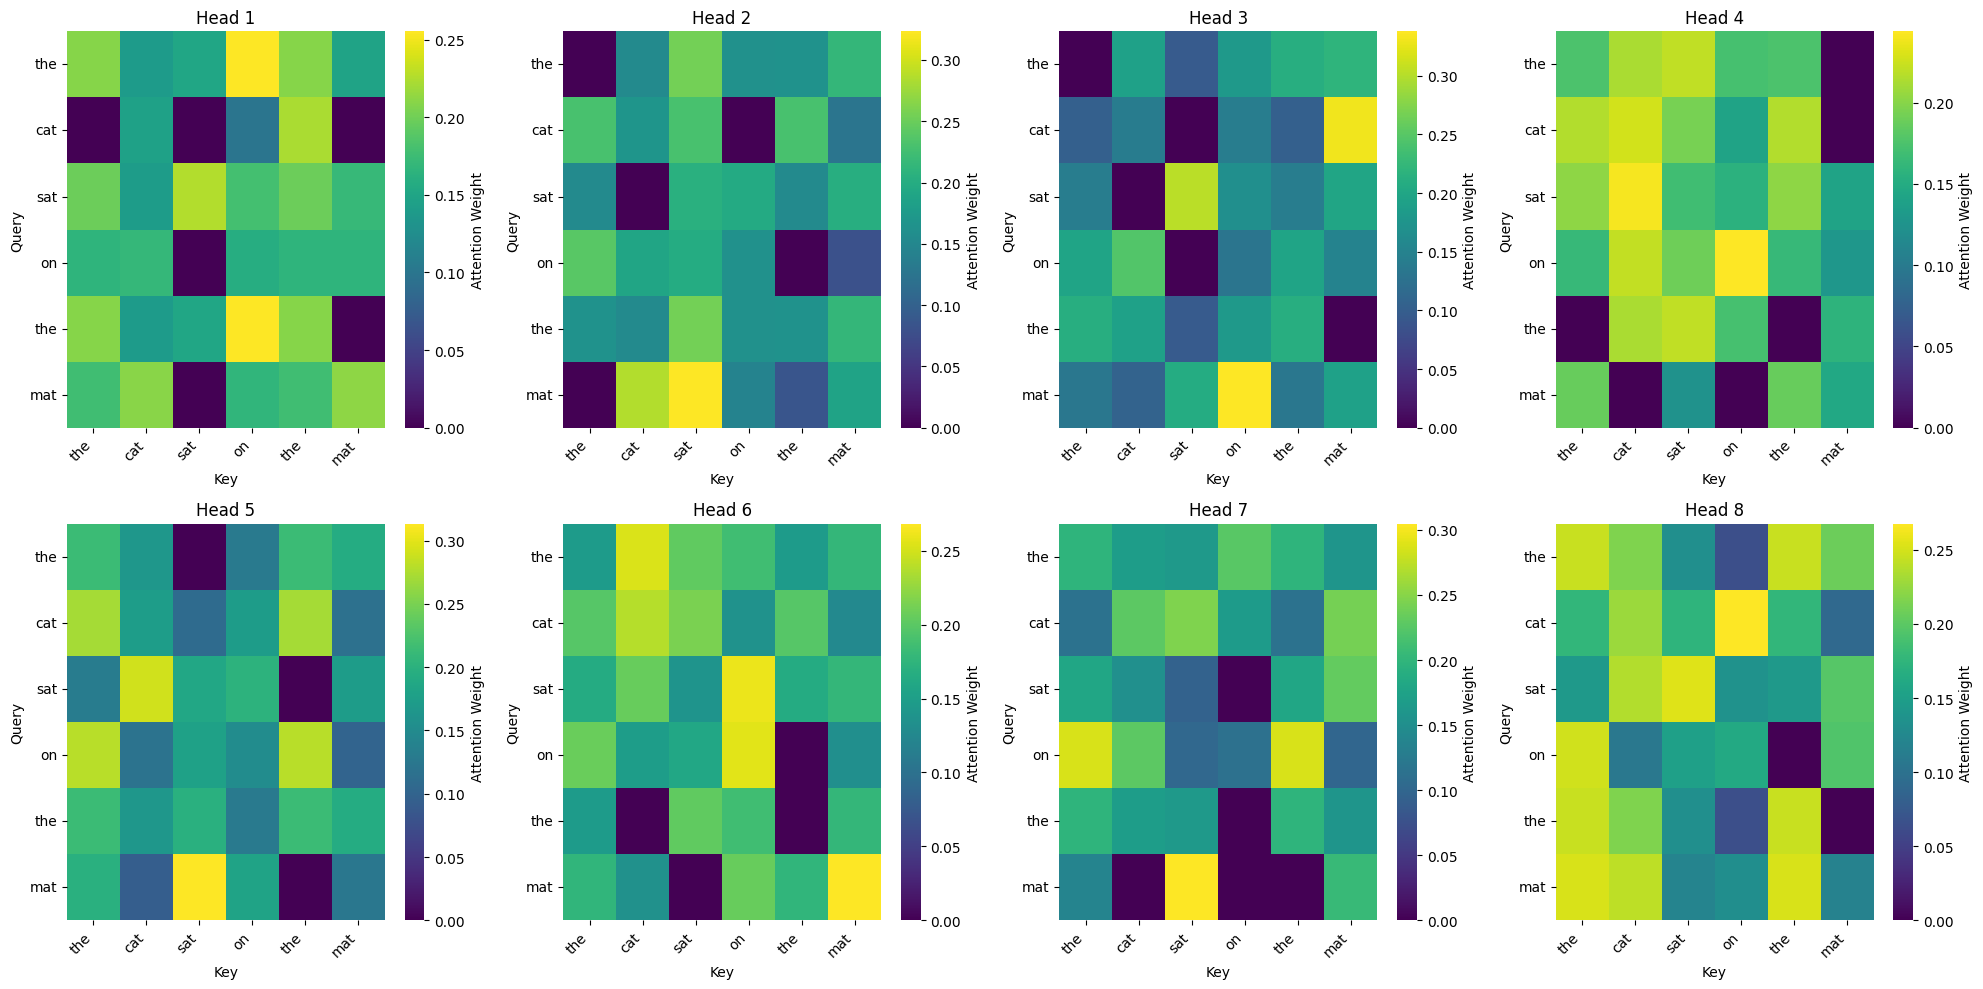

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention(attn, tokens, head_idx=0):
    attention_maps = attn[0] # [n_heads, seq_len, seq_len]
    n_heads = attention_maps.shape[0]

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes_flat = axes.flatten()
    for head_idx in range(n_heads):
        ax = axes_flat[head_idx]
        attn_map = attention_maps[head_idx].detach().numpy()

        sns.heatmap(attn_map, ax=ax, cmap="viridis", xticklabels=tokens, yticklabels=tokens, cbar=True, cbar_kws={"label":"Attention Weight"})

        ax.set_xticklabels(tokens, rotation=45, ha="right")
        ax.set_yticklabels(tokens, rotation=0)
        ax.set_title(f"Head {head_idx+1}")
        ax.set_xlabel("Key")
        ax.set_ylabel("Query")
    plt.tight_layout()
    plt.show()
plot_attention(attention, tokens)